In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import xdem
import geoutils as gu
import numpy as np
import pandas as pd
import datetime
import psutil
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray

import tools

import warnings
warnings.filterwarnings('ignore')

## Experiment 2
- Process allASTER dems
- Use outputs from ragmac_xdem/scripts/main_experiment2.py
 - `selection_opts = {"mode": None, }`
- these dems are all already aligned, but could add check and reproject as needed, e.g. https://github.com/GlacioHack/geoprofile/blob/main/geoprofile/core/core.py#L122

### Gather files

In [3]:
input_dir = '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs'
dems = sorted(glob.glob(os.path.join(input_dir, '*.tif')))

In [4]:
print(len(dems))
dems[:3]

119


['../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2000.54825814_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2000.69885137_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2001.17865240_coreg.tif']

### Stack arrays and parse dates

In [6]:
ma_stack, dt_list = tools.stack_raster_arrays(dems)
date_list = [i for i in dt_list]

### Plot gallery
- quick look

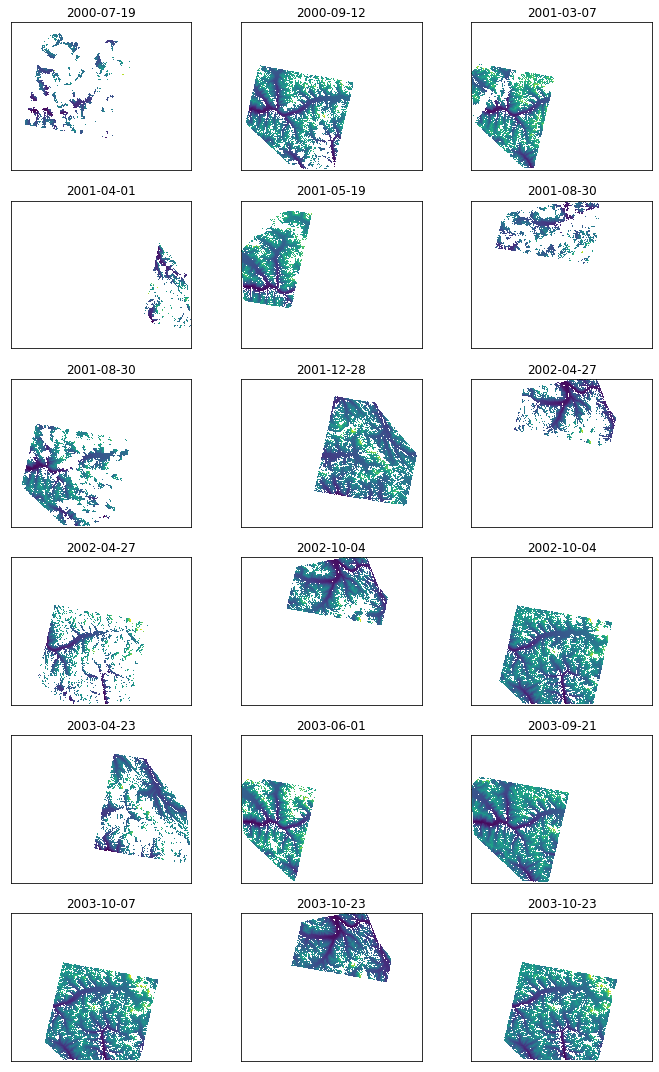

In [7]:
n = 18
tools.plot_array_gallery(ma_stack[:n], date_list[:n])

### Create count and STD maps

In [8]:
count_fn = '../data/processed/experiment_2/PK_Baltoro/count.tif'
std_fn = '../data/processed/experiment_2/PK_Baltoro/std.tif'

In [9]:
# %%capture
# !dem_mosaic --std --threads 10 -o {std_fn} {' '.join(dems)}
# !dem_mosaic --count --threads 10 -o {count_fn} {' '.join(dems)}

In [10]:
count_nmad_ma_stack,_ = tools.stack_raster_arrays([count_fn,std_fn] , parse_time_stamps=False)

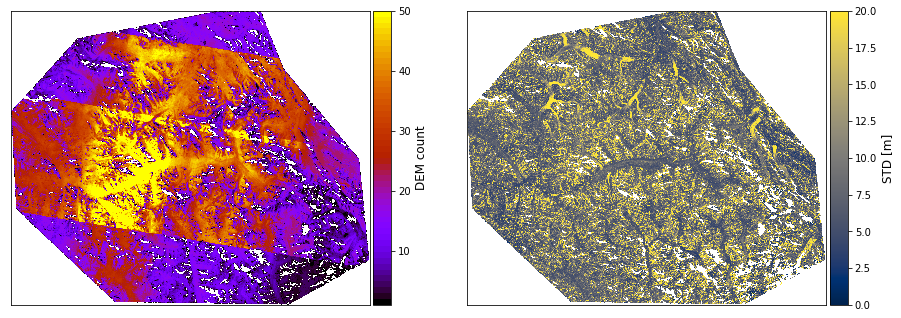

In [11]:
tools.plot_count_std(count_nmad_ma_stack)

### Select points for testing
- Four points along primary flowline
- Four randomly selected nearby points

In [12]:
center_flowline_points = ([1300,1650,2000,2300],
                          [1700,1650,1650,1600])
n = 4
points= (np.append(np.random.random_integers(1200,3000,n),center_flowline_points[0]),
         np.append(np.random.random_integers(1000,2500,n),center_flowline_points[1]))

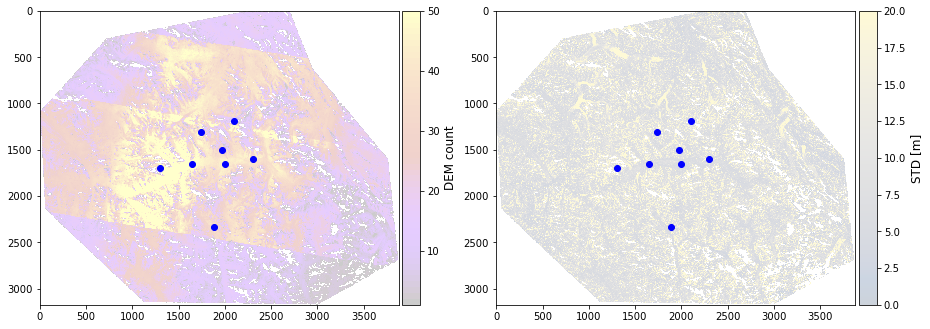

In [13]:
tools.plot_count_std(count_nmad_ma_stack,points = points,alpha=0.2, ticks_off=False)

In [14]:
# n = 5
# tools.plot_timelapse(ma_stack[:n], 
#                      points=points, 
#                      titles_list=dt_list,
#                      alpha=0.2)

### Prepare training data

In [15]:
date_time_as_float_array = np.ma.array([tools.convert_date_time_to_decimal_date(i) for i in dt_list]).data
test_stack = ma_stack[:,points[0],points[1]]

In [16]:
X_train_data = []
y_train_data = []
for i in range(test_stack.shape[1]):
    X_train, y_train = tools.remove_nan_from_training_data(date_time_as_float_array, test_stack[:,i])
    
    X_train_data.append(X_train)
    y_train_data.append(y_train)


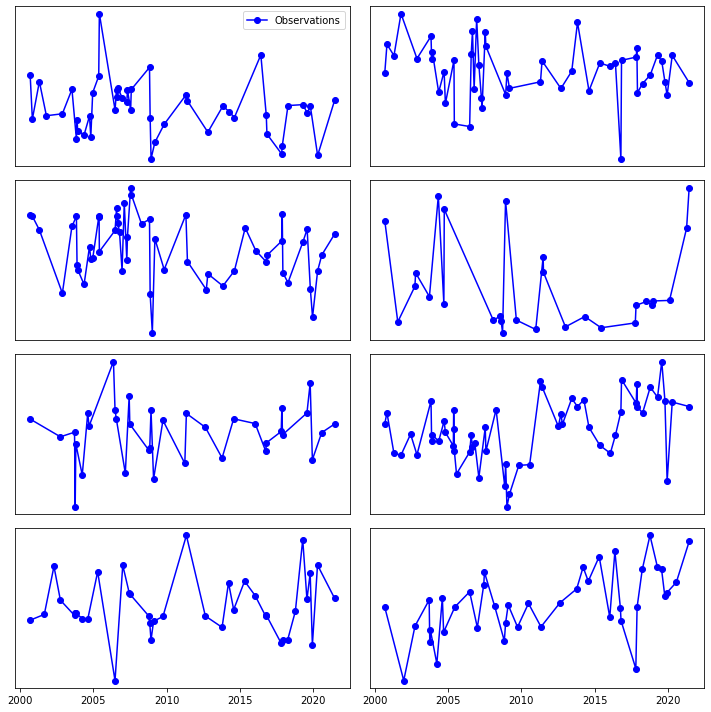

In [17]:
tools.plot_time_series_gallery(X_train_data,y_train_data)

### Fit linear models

#### Prepare time series along which to make prediction

In [183]:
X = tools.create_prediction_timeseries(start_date = '2000-01-01',
                                       end_date = '2023-01-01',
                                       dt ='M')

#### Linear regression

In [184]:
predictions = []

for i,v in enumerate(X_train_data):
    prediction, slope, intercept = tools.linreg_predict(X_train_data[i],
                                      y_train_data[i],
                                      X,
                                      method='Linear')
    predictions.append(prediction)
    
LinearReg_df = pd.DataFrame(predictions).T
LinearReg_df.index = X

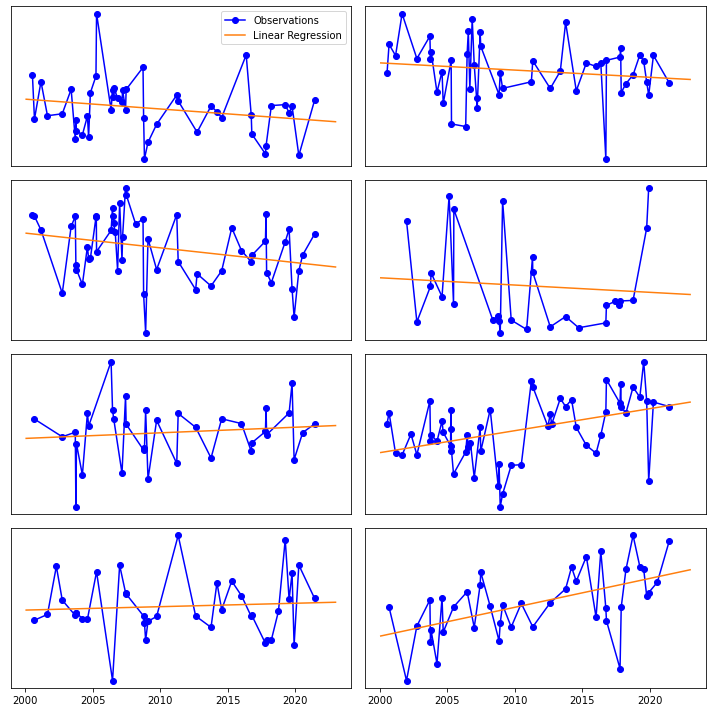

In [185]:
tools.plot_time_series_gallery(X_train_data,
                               y_train_data,
                               predictions_df_list=[LinearReg_df,],
                               legend_labels = ["Observations","Linear Regression"])

#### RANSAC

In [186]:
predictions = []

for i,v in enumerate(X_train_data):
    prediction, slope, intercept = tools.linreg_predict(X_train_data[i],
                                      y_train_data[i],
                                      X,
                                      method='RANSAC')
    predictions.append(prediction)
    
RANSAC_df = pd.DataFrame(predictions).T
RANSAC_df.index = X

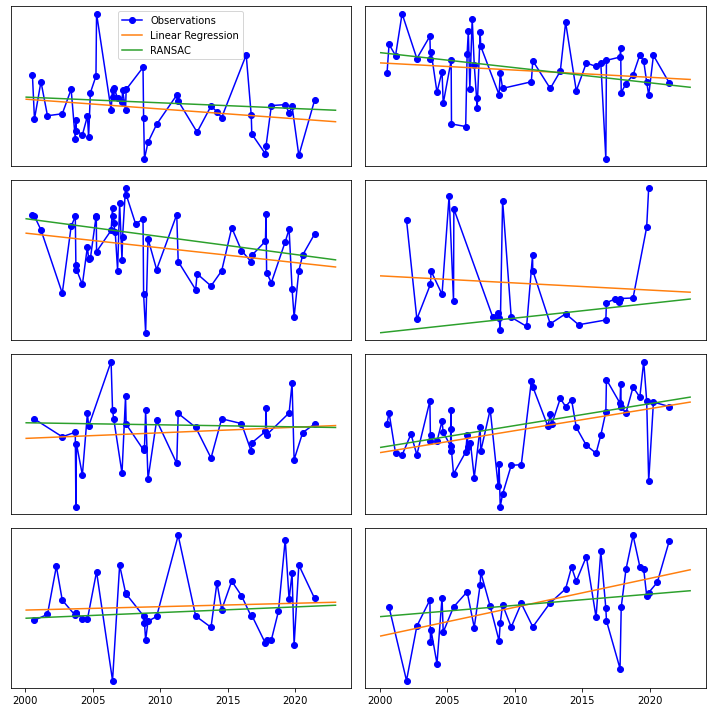

In [187]:
tools.plot_time_series_gallery(X_train_data,
                               y_train_data,
                               predictions_df_list=[LinearReg_df,RANSAC_df],
                               legend_labels = ["Observations",
                                                "Linear Regression",
                                                "RANSAC"])

#### Theil Sen

In [188]:
predictions = []

for i,v in enumerate(X_train_data):
    prediction, slope, intercept = tools.linreg_predict(X_train_data[i],
                                      y_train_data[i],
                                      X,
                                      method='TheilSen')
    predictions.append(prediction)
    
TheilSen_df = pd.DataFrame(predictions).T
TheilSen_df.index = X

In [189]:
intercept

4102.281628753392

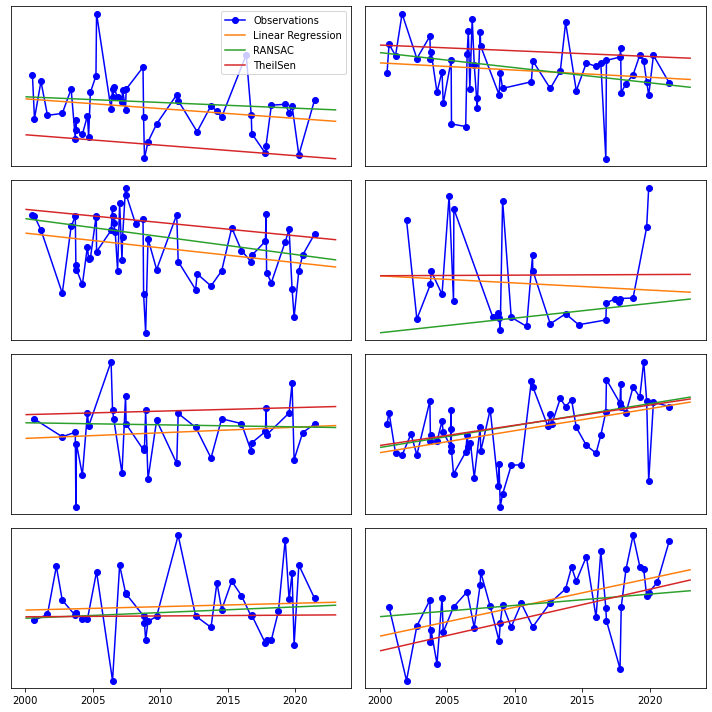

In [190]:
tools.plot_time_series_gallery(X_train_data,
                               y_train_data,
                               predictions_df_list=[LinearReg_df,RANSAC_df,TheilSen_df],
                               legend_labels = ["Observations",
                                                "Linear Regression",
                                                "RANSAC",
                                                "TheilSen"])

### Gaussian Process Regression
- Kernel adapted from [Mauna Loa](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py) example
- [Example adding error](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)
- Need to design more custom kernel as was done in Hugonnet et al. 2021
- May be possible to use an automated approach to design the kernel
 - Decompase dominant modes and iteratively evaluate performance on kernels attempting to capture each mode.


In [191]:
predictions = []
std_predictions = []

for i,v in enumerate(X_train_data):
    gaussian_process_model = tools.GPR_model(X_train_data[i], y_train_data[i], alpha=1e-10)
    mean_prediction, std_prediction = tools.GPR_predict(gaussian_process_model, X)
    predictions.append(mean_prediction)
    std_predictions.append(std_prediction)
    
GPR_df = pd.DataFrame(predictions).T
GPR_df.index = X

GPR_std_df = pd.DataFrame(std_predictions).T
GPR_std_df.index = X

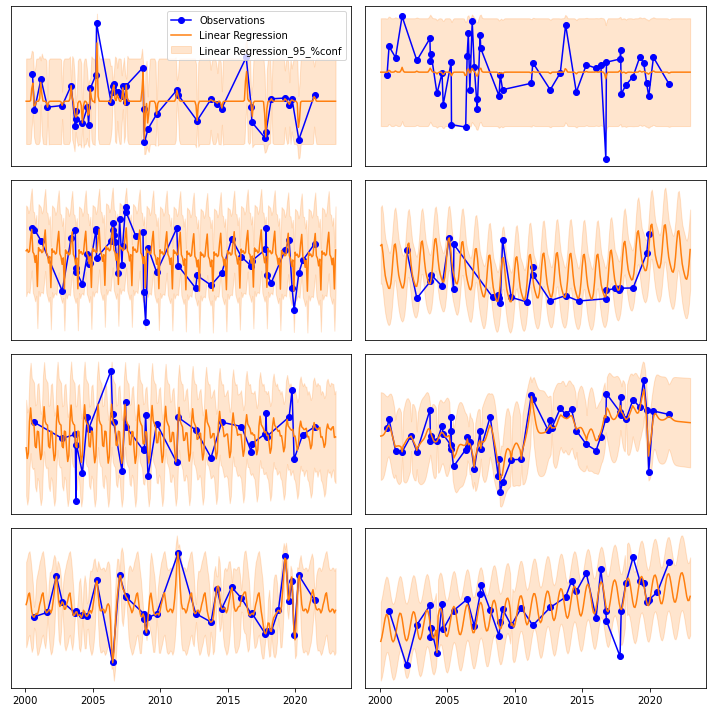

In [192]:
tools.plot_time_series_gallery(X_train_data,
                               y_train_data,
                               predictions_df_list=[GPR_df],
                               std_df_list=[GPR_std_df],
                               legend_labels = ["Observations",
                                                "Linear Regression",
                                                "RANSAC",
                                                "TheilSen",
                                                "GPR"])

### Multiprocessing linear regression
- slice the stack for testing

In [222]:
X_train = np.ma.array([tools.convert_date_time_to_decimal_date(i) for i in dt_list]).data
test_stack = ma_stack[:,1500:1550,1700:1750]

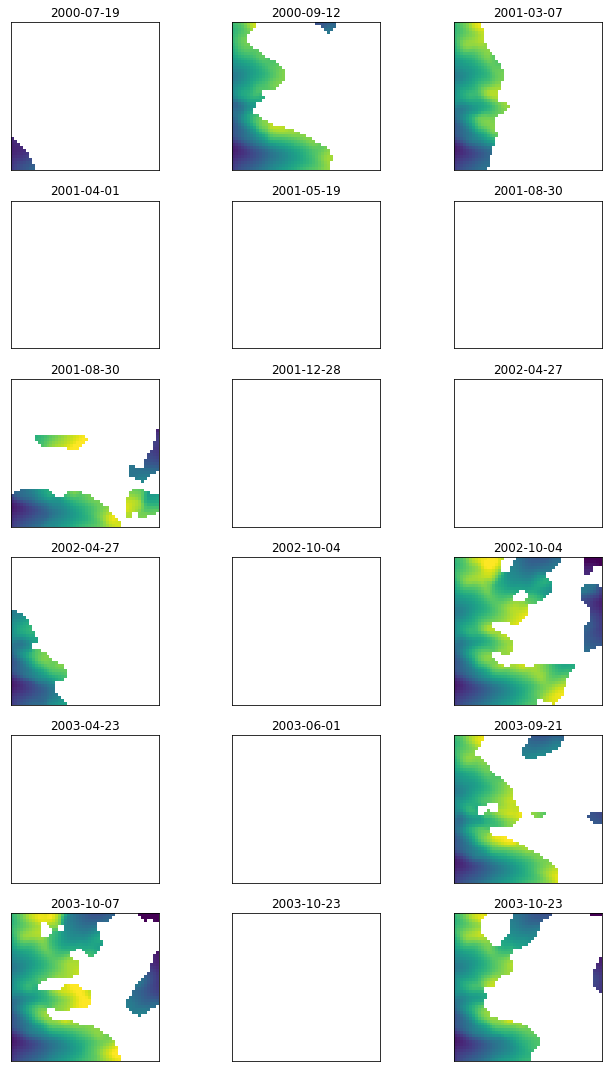

In [223]:
n = 18
tools.plot_array_gallery(test_stack[:n], date_list[:n])

#### Get pixel with 3 or more observations

In [224]:
valid_data, valid_mask_2D = tools.mask_low_count_pixels(test_stack, n_thresh = 3)

#### Run linear model

In [225]:
results = tools.linreg_run_parallel(X_train, valid_data, X, method='Linear')
prediction_stack = tools.linreg_reshape_parallel_results(results, test_stack, valid_mask_2D)

#### Get labels for predictions dates

In [226]:
X_dates = [tools.convert_decimal_date_to_date_time(i)[0] for i in X]

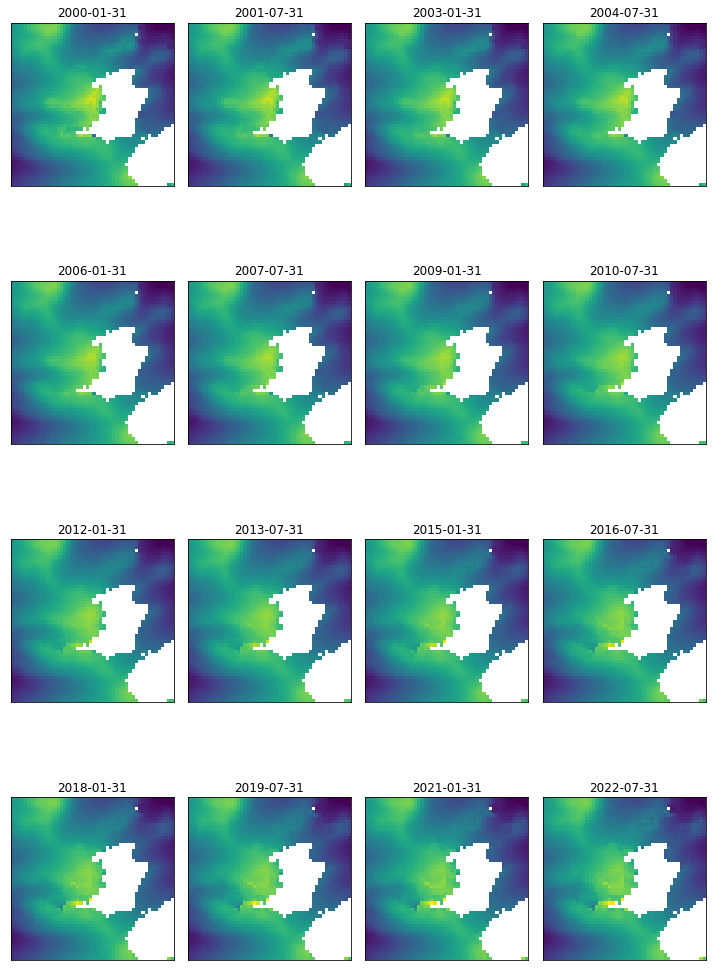

In [227]:
step = 20
tools.plot_array_gallery(prediction_stack[::n], X_dates[::n])

In [233]:
# tools.plot_timelapse(prediction_stack[::n], 
#                      titles_list=X_dates[::n])

### Multiprocessing GPR
- slice the stack for testing

In [229]:
valid_data, valid_mask_2D = tools.mask_low_count_pixels(test_stack, n_thresh = 3)

results = tools.GPR_run_parallel(X_train, valid_data, X, method='Linear')

In [230]:
prediction_stack = tools.GPR_reshape_parallel_results(results, test_stack, valid_mask_2D)

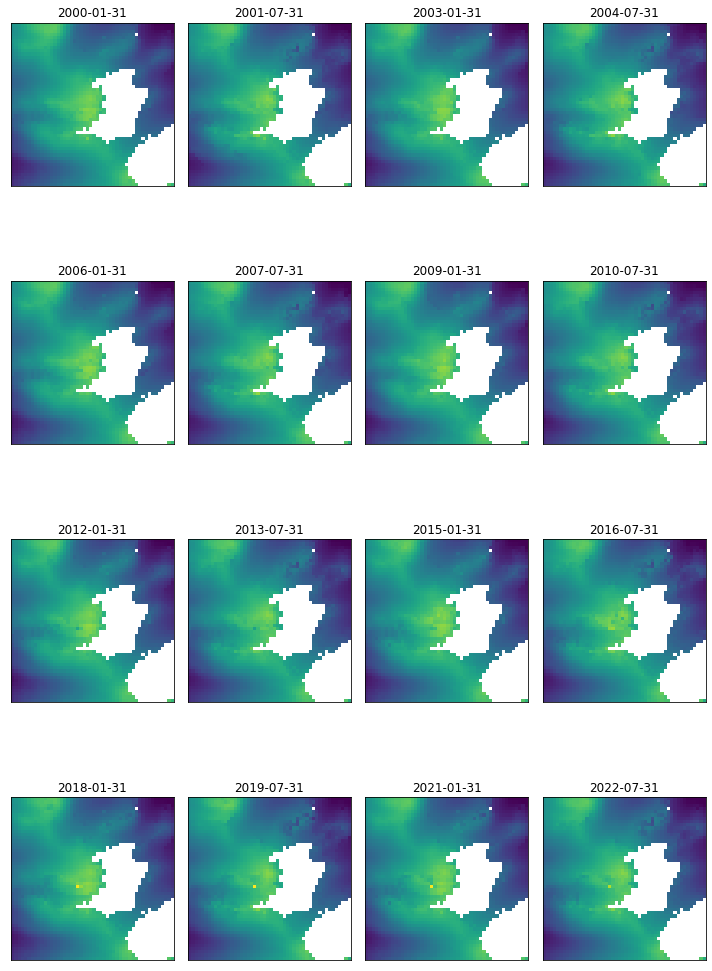

In [231]:
step = 20
tools.plot_array_gallery(prediction_stack[::n], X_dates[::n])

In [234]:
# tools.plot_timelapse(prediction_stack[::n], 
#                      titles_list=X_dates[::n])